# Tensor Pipeline

## Setting Path

In [1]:
import sys
sys.path.append('../Code Files')
sys.path.append('../Data')

## Import Libraries

In [2]:
import datetime
import numpy as np
import dill
from KFoldCV_PyTorch import KFoldCV
from train_test_PyTorch import train_test
from DataGenerationB_PyTorch import *
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Import Data

In [3]:
import pickle
pkl_file = "../Data/Bounded_Var_Time_2024-03-31 20_19_12, intercept_5,n_train_5000, n_test_1000, tensor_dimensions_[32 32], tensor_mode_ranks_[4 4], separation_rank_2.pkl"
file= open(pkl_file, 'rb')
data = pickle.load(file)
file.close()

X_train_Full = data[0]
print(data[0].shape)

Y_train_Full = data[1]
print(data[1].shape)

X_test_Full = data[2]
print(data[2].shape)

Y_test_Full = data[3]
print(data[3].shape)

B_tensored = data[4]
print(data[4].shape)

(5000, 32, 32)
(5000,)
(1000, 32, 32)
(1000,)
(32, 32)


## Subset Data

In [7]:
n_train_all = [1000]
n_test = 100

tensor_dimensions = np.array([32, 32])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2


In [8]:
for i,n_train in enumerate(n_train_all):
  print('Number of Samples:',n_train,'---------------------------------------------------------------------------------------------------------------------------')

  #Subset X_train and Y_train
  X_train = X_train_Full[0:(n_train),:,:]
  Y_train = Y_train_Full[0:(n_train)]
  

  #Subset X_test and Y_test
  X_test = X_test_Full[0:(n_test),:,:]
  Y_test = Y_test_Full[0:(n_test)]

  #Preprocessing

  # Reshape the 3D array to a 2D array where each row represents a sample
  # The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
  # We reshape it to (n_samples, n_features_per_sample * n_dimensions)


  X_train_2D = X_train.reshape(n_train, -1)
  X_test_2D = X_test.reshape(n_test,-1)


  # Initialize StandardScaler
  scaler = StandardScaler(with_std = False) #standard scalar only

  # Fit scaler on train data and transform train data
  X_train_scaled = scaler.fit_transform(X_train_2D)
  # Transform test data using the scaler fitted on train data
  X_test_scaled = scaler.transform(X_test_2D)

  # Reshape the scaled data back to 3D
  X_train = X_train_scaled.reshape(n_train, tensor_dimensions[0],tensor_dimensions[1])
  X_test  = X_test_scaled.reshape(n_test, tensor_dimensions[0],tensor_dimensions[1])

  #average response value
  Y_train_mean = np.mean(Y_train)
  # Mean centering y_train and y_test
  Y_train = Y_train - Y_train_mean


  print("Sample mean for each feature (across samples):",scaler.mean_)
  print("Sample variance for each feature (across samples):",scaler.var_)
  print('Response Average:',Y_train_mean)

  #For now, define finite alpha set that we are searching over
  alphas = [0,0.1,0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5, 3, 5, 4,10,15,20,50,100]

  #Define Number of Folds we want
  k_folds = 5
  hypers = {'max_iter': 100, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}
  lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information = KFoldCV(X_train, Y_train, B_tensored, alphas, k_folds, hypers,Y_train_mean)

  hypers = {'max_iter': 100, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}
  normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values = train_test(X_train, Y_train, X_test, Y_test, B_tensored, lambda1, hypers, Y_train_mean)

  #Get current time and store in variable
  formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  max_iter = hypers['max_iter']
  pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Experimental Results/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

  print("Error Record on Training _ After K-Fold CV")
  print("Validation Normalized Estimation Error: ", validation_normalized_estimation_error)
  print("Validation NMSE Losses: ", validation_nmse_losses)
  print("Validation Correlations: ", validation_correlations)
  print("Validation R2 Scores: ", validation_R2_scores)

  print("Error Report on Testing _ With best Lambda")
  print("Alpha chosen for model: ", lambda1)
  print("Test Normalized Estimation Error: ", normalized_estimation_error)
  print("Test NMSE Loss: ", test_nmse_loss)
  print("Test R2 Loss: ", test_R2_loss)
  print("Test Correlation: ", test_correlation)

  with open(pkl_file, "wb") as file:
    dill.dump((X_train_Full, Y_train_Full, X_test_Full, Y_test_Full, B_tensored, lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information, normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values), file)

Number of Samples: 1000 ---------------------------------------------------------------------------------------------------------------------------
Sample mean for each feature (across samples): [-0.02231123  0.0239631   0.016219   ... -0.0093375   0.00688489
 -0.002867  ]
Sample variance for each feature (across samples): None
Response Average: 4.543979727602281
Fold = 0, Alpha = 0, Normalized Estimation Error: 0.3396940219329226, NMSE: 0.37985784690176844, Correlation: 0.820664831413786, R^2 Score: 0.6126759955947522
Fold = 0, Alpha = 0.1, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 0, Alpha = 0.3, Normalized Estimation Error: 0.18415132730407527, NMSE: 0.21702642165471475, Correlation: 0.9040278596279925, R^2 Score: 0.7787078945909369
Fold = 0, Alpha = 0.5, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 0, Alpha = 0.7, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan


/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/PyTorch Solver_From_Scratch/Jupyter Notebooks/../Code Files/lsr_bcd_regression_PyTorch.py:120: RuntimeWarning: invalid value encountered in subtract
  factor_residuals[s][k] = np.linalg.norm(Bk1 - Bk)


Fold = 0, Alpha = 0.9, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 0, Alpha = 1, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 0, Alpha = 1.5, Normalized Estimation Error: 0.27277417150413386, NMSE: 0.2551163743284644, Correlation: 0.8829879941812429, R^2 Score: 0.7398692787309931
Fold = 0, Alpha = 2, Normalized Estimation Error: 0.22027033098655444, NMSE: 0.2758858365588628, Correlation: 0.8703438835378299, R^2 Score: 0.7186915899033571
Fold = 0, Alpha = 2.5, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 0, Alpha = 3, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 0, Alpha = 5, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 0, Alpha = 4, Normalized Estimation Error: 0.1999557439262912, NMSE: 0.2147860596873068, Correlation: 0.903268693860991, R^2 Score: 0.7809922911766893
Fold = 0, Alpha = 10,

/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/PyTorch Solver_From_Scratch/Jupyter Notebooks/../Code Files/lsr_bcd_regression_PyTorch.py:162: RuntimeWarning: invalid value encountered in subtract
  core_residual = np.linalg.norm(Gk1 - Gk)


Fold = 1, Alpha = 2, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 1, Alpha = 2.5, Normalized Estimation Error: 0.1812471810988344, NMSE: 0.21811375870365415, Correlation: 0.9134724391457846, R^2 Score: 0.7806642136257519
Fold = 1, Alpha = 3, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 1, Alpha = 5, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan
Fold = 1, Alpha = 4, Normalized Estimation Error: 0.22218539743115553, NMSE: 0.22812923434552218, Correlation: 0.9006469844484599, R^2 Score: 0.7705926241997684
Fold = 1, Alpha = 10, Normalized Estimation Error: nan, NMSE: nan, Correlation: nan, R^2 Score: nan


KeyboardInterrupt: 

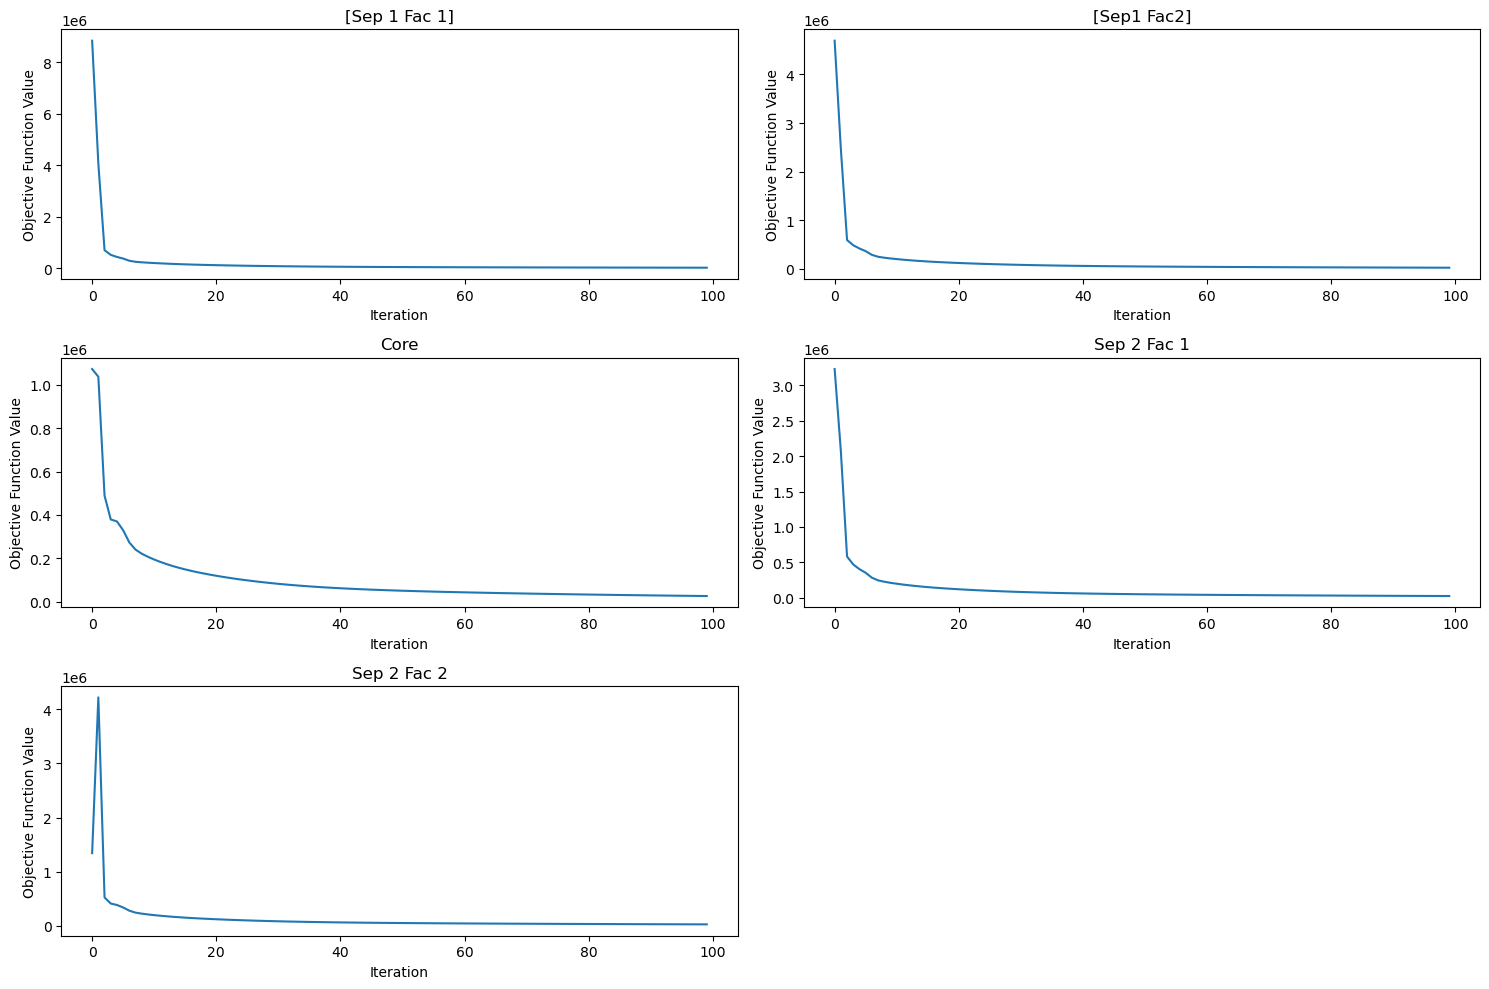

In [ ]:
# Set up a figure to hold all the subplots
plt.figure(figsize=(15, 10))

# Plot each specified slice in a different subplot
plt.subplot(3, 2, 1)  # 3 rows, 2 columns, 1st subplot
plt.plot(objective_function_values[0, 0, :], label='[0,0,:]')
plt.title('[Sep 1 Fac 1]')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

plt.subplot(3, 2, 2)  # 3 rows, 2 columns, 2nd subplot
plt.plot(objective_function_values[0, 1, :], label='[0,1,:]')
plt.title('[Sep1 Fac2]')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

plt.subplot(3, 2, 3)  # 3 rows, 2 columns, 3rd subplot
plt.plot(objective_function_values[0, 2, :], label='[0,2,:]')
plt.title('Core')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

plt.subplot(3, 2, 4)  # 3 rows, 2 columns, 4th subplot
plt.plot(objective_function_values[1, 0, :], label='[1,0,:]')
plt.title('Sep 2 Fac 1')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

plt.subplot(3, 2, 5)  # 3 rows, 2 columns, 5th subplot
plt.plot(objective_function_values[1, 1, :], label='[1,1,:]')
plt.title('Sep 2 Fac 2')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

# Adjust the layout so that all subplots are spaced nicely
plt.tight_layout()

# Show the plot
plt.show()